# Advertisement Classification Using Naive Bayes 
In this notebook, we develop, train, and test a Naive Bayes model (also with Additive Smoothing applied) for classification of Divar ads based on the title and descriptions provided.

In this project, we're interested in classifying ads only based on their provided title and descriptions and based on a Naive Bayes classification algorithm. Our approach will be to first pre-process the data, then formally define and solve the problem, then also include Additive Smoothing, and finally asses the results. The approach is clearly described at each of the following steps, and also the probelms are answerd.

## 1 - Packages
First, we import all the python packages that we'll need during this assignment.

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python
- [pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
- [matplotlib](https://matplotlib.org/) is a comprehensive library for creating static, animated, and interactive visualizations in Python
- [hazm](https://github.com/sobhe/hazm) is a NLP preprocessing library for Persian

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hazm

# Setting matplotlib plotting options
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline

## 2 - Dataset
We load the data from the train and test datasets into the corresponding pandas DataFrames using `pd.read_csv(...)`.

In [2]:
data_train = pd.read_csv('Data/divar_train.csv', encoding='utf-8')
data_test = pd.read_csv('Data/divar_test.csv')

The two dataframes contain 3 columns each, giving each example (row) three different features, which include the title, the  description, and the describing categries.The head of these two loaded datasets is shown below.

In [3]:
data_train.head()

,title,description,categories
0,بلبل خرمایی,سه عدد بلبل خرمایی سه ماهه.از وقتی جوجه بودن خ...,leisure-hobbies
1,عینک اسکی در حد,عینک اسکی دبل لنز مارک يو وكس در حد نو اصلی م...,leisure-hobbies
2,تکیه سر تویوتا پرادو,پارچه ای سالم و تمیز.,vehicles
3,مجسمه کریستال24%,مجسمه دکوری کریستال بالرین Rcr24%,for-the-home
4,کیف و ساک,هر 2 کاملا تمیز هستند,personal


In [4]:
data_test.head()

,title,description,categories
0,کیف مجلسی نو,کیف مجلسی نوی نو,personal
1,دیوار کوب نمدی تزیینی,مناسب برای جهاز عروس,for-the-home
2,دو تیکه بسیار بسیار تمیز و سالم,با کشوی مخفی و شیک,for-the-home
3,مودم,سلام مودم سالم با وسایلش،دیگه ب کارم نمیاد \nم...,electronic-devices
4,تعداد18عددبوقلمون به قیمت عمده,سلام تعدای بوقلمون دارم به علت جابه جایی به فر...,leisure-hobbies


## 3 - Pre-Processing
Here we will first append the strings of the `title` and `description` columns, then normalize them by applying removing stop words, end of line characters, and lastly by stemming the words i neach of the sentences. We also try lemmatization on the strings, but not precede with it.

In the following block, we're appending the title and description columns:

In [5]:
data_train['text'] = data_train['title'] + ' ' +  data_train['description']
data_test['text'] = data_test['title'] + ' ' +data_test['description']

### 3.1 - Basic Normalization
We import the list of stop words to be removed out of each string. We also define the `remove_stop_words(...)` lambda function, which would remove every occurance of stop words in the given text.
**Note**: By stop words, we mean all actual "stop words," all end of line characters, and all punctuation marks as included in the `persian_stop_words.txt` file hereafter.

In [6]:
with open('persian_stop_words.txt') as f:
    stop_words_and_puctuations = f.read()
    stop_words_and_puctuations = stop_words_and_puctuations.split('\n')

print('Head of the stop_words_and_puctuations list:')        
print(stop_words_and_puctuations[:25], '\n')

remove_stop_words = lambda lst, stop_words_and_puctuations: list(filter(lambda a: a not in stop_words_and_puctuations, lst))

Head of the stop_words_and_puctuations list:
['!', '"', '#', '(', ')', '*', ',', '-', '.', '/', ':', '[', ']', '«', '\\n', '\\r', '»', '،', '؛', '؟', 'آباد', 'آخ', 'آخر', 'آخرها', 'آخه'] 



We do apply the defined function, `remove_stop_words`, to the tokenization output of each of the strings in the `text` columns of both the train and test dataframes. 

**Note**: The `hazm.word_tokenize(...)` function, splits the text into the building words, also considering some basic grammatical rules of the language.

In [7]:
data_train['text_normalized'] = data_train['text'].apply(hazm.word_tokenize).apply(remove_stop_words, stop_words_and_puctuations=stop_words_and_puctuations)
data_test['text_normalized'] = data_test['text'].apply(hazm.word_tokenize).apply(remove_stop_words, stop_words_and_puctuations=stop_words_and_puctuations)

Having run the above cell, the `text_normalized` columns of each dataframe should now be a list of all non-stop-word characters. This is shown in the following two cells:

In [8]:
data_train

,title,description,categories,text,text_normalized
0,بلبل خرمایی,سه عدد بلبل خرمایی سه ماهه.از وقتی جوجه بودن خ...,leisure-hobbies,بلبل خرمایی سه عدد بلبل خرمایی سه ماهه.از وقتی...,"[بلبل, خرمایی, سه, عدد, بلبل, خرمایی, سه, ماهه..."
1,عینک اسکی در حد,عینک اسکی دبل لنز مارک يو وكس در حد نو اصلی م...,leisure-hobbies,عینک اسکی در حد عینک اسکی دبل لنز مارک يو وكس ...,"[عینک, اسکی, حد, عینک, اسکی, دبل, لنز, مارک, ي..."
2,تکیه سر تویوتا پرادو,پارچه ای سالم و تمیز.,vehicles,تکیه سر تویوتا پرادو پارچه ای سالم و تمیز.,"[تکیه, تویوتا, پرادو, پارچه, سالم, تمیز]"
3,مجسمه کریستال24%,مجسمه دکوری کریستال بالرین Rcr24%,for-the-home,مجسمه کریستال24% مجسمه دکوری کریستال بالرین Rc...,"[مجسمه, کریستال, 24, %, مجسمه, دکوری, کریستال,..."
4,کیف و ساک,هر 2 کاملا تمیز هستند,personal,کیف و ساک هر 2 کاملا تمیز هستند,"[کیف, ساک, 2, تمیز]"
...,...,...,...,...,...
10195,ان هاش 85,نیمه دوم همه چی به شرط در حد خشک 260تا کار,vehicles,ان هاش 85 نیمه دوم همه چی به شرط در حد خشک 260...,"[هاش, 85, نیمه, شرط, حد, خشک, 260, کار]"
10196,405 دوگانه کارخانه. تمیز,فابریک 4 حلقه لاستیک 205 نو بیمه یکسال تخفیف ب...,vehicles,405 دوگانه کارخانه. تمیز فابریک 4 حلقه لاستیک ...,"[405, دوگانه, کارخانه, تمیز, فابریک, 4, حلقه, ..."
10197,بخاری گازی دودکش دار پلار,بخاری نو و بسیار تمیز هستش\nبا مشتری واقعی کنا...,for-the-home,بخاری گازی دودکش دار پلار بخاری نو و بسیار تمی...,"[بخاری, گازی, دودکش, پلار, بخاری, نو, تمیز, مش..."
10198,نر کله برنجی چتری,سلام به دلیل کمبود جا واسباب کشی به کمترین قیم...,leisure-hobbies,نر کله برنجی چتری سلام به دلیل کمبود جا واسباب...,"[نر, کله, برنجی, چتری, سلام, دلیل, کمبود, واسب..."


In [9]:
data_test

,title,description,categories,text,text_normalized
0,کیف مجلسی نو,کیف مجلسی نوی نو,personal,کیف مجلسی نو کیف مجلسی نوی نو,"[کیف, مجلسی, نو, کیف, مجلسی, نوی, نو]"
1,دیوار کوب نمدی تزیینی,مناسب برای جهاز عروس,for-the-home,دیوار کوب نمدی تزیینی مناسب برای جهاز عروس,"[دیوار, کوب, نمدی, تزیینی, مناسب, جهاز, عروس]"
2,دو تیکه بسیار بسیار تمیز و سالم,با کشوی مخفی و شیک,for-the-home,دو تیکه بسیار بسیار تمیز و سالم با کشوی مخفی و...,"[تیکه, تمیز, سالم, کشوی, مخفی]"
3,مودم,سلام مودم سالم با وسایلش،دیگه ب کارم نمیاد \nم...,electronic-devices,مودم سلام مودم سالم با وسایلش،دیگه ب کارم نمیا...,"[مودم, سلام, مودم, سالم, وسایلش, ب, کارم, نمیا..."
4,تعداد18عددبوقلمون به قیمت عمده,سلام تعدای بوقلمون دارم به علت جابه جایی به فر...,leisure-hobbies,تعداد18عددبوقلمون به قیمت عمده سلام تعدای بوقل...,"[تعداد, 18, عددبوقلمون, قیمت, سلام, تعدای, بوق..."
...,...,...,...,...,...
1795,باسکول 300کیلویی,سالمه سالمه بشرط\nقیمت نوش داخل بازار600تومنه,businesses,باسکول 300کیلویی سالمه سالمه بشرط\nقیمت نوش دا...,"[باسکول, 300, کیلویی, سالمه, سالمه, بشرط, قیمت..."
1796,میز مدیریتی با کنفرانس,میز مدیریتی با کنفرانس \nتمیز سالم بدون خط و خش,businesses,میز مدیریتی با کنفرانس میز مدیریتی با کنفرانس ...,"[میز, مدیریتی, کنفرانس, میز, مدیریتی, کنفرانس,..."
1797,باند aiwa,سالم،با اسپیکر,electronic-devices,باند aiwa سالم،با اسپیکر,"[باند, aiwa, سالم, اسپیکر]"
1798,عروس هلندی مولد,پنج تا عروس هلندی، دو جفت ویک تک،یه جفتش دم ت...,leisure-hobbies,عروس هلندی مولد پنج تا عروس هلندی، دو جفت ویک...,"[عروس, هلندی, مولد, عروس, هلندی, جفت, ویک, تک,..."


### 3.2 Stemming and Lemmatization
In this section, we do apply stemming and lemmatization to the `text_normalized` columns of the dataframes to lower the variance of the distibutions of words in out dataframes. Please note that although we try out lemmatization, we don't use it further in our actual NLP model, as it comes with a great computional cost over stemming but adds no real extra-value to our model, as we don't care if the generated lammas are a member of the language or not.

#### 3.2.1 - Stemming
stemming is the process of reducting inflection words into their corresponding roots to lower the distribution of words in the output sentence/dataset. Here we use the `hazm.Stemmer` class for stemming.

We first define a stemmer function to be applied to each of the rows our `text_normalized` columns, then apply it both dataframes and store the results in the corresponding `text_normalized_stemmed` columns:

In [10]:
stemmer = hazm.Stemmer()
stem_tokenized_sentence = lambda sentence, stemmer: [stemmer.stem(word) for word in sentence]

data_train['text_normalized_stemmed'] = data_train['text_normalized'].apply(stem_tokenized_sentence, stemmer=stemmer)
data_train

,title,description,categories,text,text_normalized,text_normalized_stemmed
0,بلبل خرمایی,سه عدد بلبل خرمایی سه ماهه.از وقتی جوجه بودن خ...,leisure-hobbies,بلبل خرمایی سه عدد بلبل خرمایی سه ماهه.از وقتی...,"[بلبل, خرمایی, سه, عدد, بلبل, خرمایی, سه, ماهه...","[بلبل, خرما, سه, عدد, بلبل, خرما, سه, ماهه, جو..."
1,عینک اسکی در حد,عینک اسکی دبل لنز مارک يو وكس در حد نو اصلی م...,leisure-hobbies,عینک اسکی در حد عینک اسکی دبل لنز مارک يو وكس ...,"[عینک, اسکی, حد, عینک, اسکی, دبل, لنز, مارک, ي...","[عینک, اسک, حد, عینک, اسک, دبل, لنز, مارک, يو,..."
2,تکیه سر تویوتا پرادو,پارچه ای سالم و تمیز.,vehicles,تکیه سر تویوتا پرادو پارچه ای سالم و تمیز.,"[تکیه, تویوتا, پرادو, پارچه, سالم, تمیز]","[تکیه, تویوتا, پرادو, پارچه, سال, تمیز]"
3,مجسمه کریستال24%,مجسمه دکوری کریستال بالرین Rcr24%,for-the-home,مجسمه کریستال24% مجسمه دکوری کریستال بالرین Rc...,"[مجسمه, کریستال, 24, %, مجسمه, دکوری, کریستال,...","[مجسمه, کریستال, 24, %, مجسمه, دکور, کریستال, ..."
4,کیف و ساک,هر 2 کاملا تمیز هستند,personal,کیف و ساک هر 2 کاملا تمیز هستند,"[کیف, ساک, 2, تمیز]","[کیف, ساک, 2, تمیز]"
...,...,...,...,...,...,...
10195,ان هاش 85,نیمه دوم همه چی به شرط در حد خشک 260تا کار,vehicles,ان هاش 85 نیمه دوم همه چی به شرط در حد خشک 260...,"[هاش, 85, نیمه, شرط, حد, خشک, 260, کار]","[, 85, نیمه, شرط, حد, خشک, 260, کار]"
10196,405 دوگانه کارخانه. تمیز,فابریک 4 حلقه لاستیک 205 نو بیمه یکسال تخفیف ب...,vehicles,405 دوگانه کارخانه. تمیز فابریک 4 حلقه لاستیک ...,"[405, دوگانه, کارخانه, تمیز, فابریک, 4, حلقه, ...","[405, دوگانه, کارخانه, تمیز, فابریک, 4, حلقه, ..."
10197,بخاری گازی دودکش دار پلار,بخاری نو و بسیار تمیز هستش\nبا مشتری واقعی کنا...,for-the-home,بخاری گازی دودکش دار پلار بخاری نو و بسیار تمی...,"[بخاری, گازی, دودکش, پلار, بخاری, نو, تمیز, مش...","[بخار, گاز, دودک, پلار, بخار, نو, تمیز, مشتر, ..."
10198,نر کله برنجی چتری,سلام به دلیل کمبود جا واسباب کشی به کمترین قیم...,leisure-hobbies,نر کله برنجی چتری سلام به دلیل کمبود جا واسباب...,"[نر, کله, برنجی, چتری, سلام, دلیل, کمبود, واسب...","[نر, کله, برنج, چتر, سلا, دلیل, کمبود, واسباب,..."


In [11]:
data_test['text_normalized_stemmed'] = data_test['text_normalized'].apply(stem_tokenized_sentence, stemmer=stemmer)
data_test

,title,description,categories,text,text_normalized,text_normalized_stemmed
0,کیف مجلسی نو,کیف مجلسی نوی نو,personal,کیف مجلسی نو کیف مجلسی نوی نو,"[کیف, مجلسی, نو, کیف, مجلسی, نوی, نو]","[کیف, مجلس, نو, کیف, مجلس, نو, نو]"
1,دیوار کوب نمدی تزیینی,مناسب برای جهاز عروس,for-the-home,دیوار کوب نمدی تزیینی مناسب برای جهاز عروس,"[دیوار, کوب, نمدی, تزیینی, مناسب, جهاز, عروس]","[دیوار, کوب, نمد, تزیین, مناسب, جهاز, عروس]"
2,دو تیکه بسیار بسیار تمیز و سالم,با کشوی مخفی و شیک,for-the-home,دو تیکه بسیار بسیار تمیز و سالم با کشوی مخفی و...,"[تیکه, تمیز, سالم, کشوی, مخفی]","[تیکه, تمیز, سال, کشو, مخف]"
3,مودم,سلام مودم سالم با وسایلش،دیگه ب کارم نمیاد \nم...,electronic-devices,مودم سلام مودم سالم با وسایلش،دیگه ب کارم نمیا...,"[مودم, سلام, مودم, سالم, وسایلش, ب, کارم, نمیا...","[مود, سلا, مود, سال, وسایل, ب, کار, نمیاد, مار..."
4,تعداد18عددبوقلمون به قیمت عمده,سلام تعدای بوقلمون دارم به علت جابه جایی به فر...,leisure-hobbies,تعداد18عددبوقلمون به قیمت عمده سلام تعدای بوقل...,"[تعداد, 18, عددبوقلمون, قیمت, سلام, تعدای, بوق...","[تعداد, 18, عددبوقلمون, قیم, سلا, تعدا, بوقلمو..."
...,...,...,...,...,...,...
1795,باسکول 300کیلویی,سالمه سالمه بشرط\nقیمت نوش داخل بازار600تومنه,businesses,باسکول 300کیلویی سالمه سالمه بشرط\nقیمت نوش دا...,"[باسکول, 300, کیلویی, سالمه, سالمه, بشرط, قیمت...","[باسکول, 300, کیلو, سالمه, سالمه, بشرط, قیم, ن..."
1796,میز مدیریتی با کنفرانس,میز مدیریتی با کنفرانس \nتمیز سالم بدون خط و خش,businesses,میز مدیریتی با کنفرانس میز مدیریتی با کنفرانس ...,"[میز, مدیریتی, کنفرانس, میز, مدیریتی, کنفرانس,...","[میز, مدیریت, کنفرانس, میز, مدیریت, کنفرانس, ت..."
1797,باند aiwa,سالم،با اسپیکر,electronic-devices,باند aiwa سالم،با اسپیکر,"[باند, aiwa, سالم, اسپیکر]","[باند, aiwa, سال, اسپیکر]"
1798,عروس هلندی مولد,پنج تا عروس هلندی، دو جفت ویک تک،یه جفتش دم ت...,leisure-hobbies,عروس هلندی مولد پنج تا عروس هلندی، دو جفت ویک...,"[عروس, هلندی, مولد, عروس, هلندی, جفت, ویک, تک,...","[عروس, هلند, مولد, عروس, هلند, جف, ویک, تک, جف..."


#### 3.2.2 Lemmatization
Lemmatization works just like stemming, with the difference that it always returns lemmas of te given words, i.e. the returned word will be a member of the language because it searcher corpora to find the lemmas. Here we use the `hazm.Lemmatizer` class for lemmatization.

Just like for stemming, we define a lemmatizer function to be applied to each tokenized sentence, and apply it to columns `text_normalized` of the dataframes. Note that we don't store the results in our dataframes, because we're not going to use them further on.

In [12]:
lemmatizer = hazm.Lemmatizer()
lemmatize_tokenized_sentence = lambda sentence, lemmatizer: [lemmatizer.lemmatize(word) for word in sentence]

data_train['text_normalized'].apply(lemmatize_tokenized_sentence, lemmatizer=lemmatizer)

0        [بلبل, خرما, سه, عدد, بلبل, خرما, سه, ماهه, جو...
1        [عینک, اسکی, حد, عینک, اسکی, دبل, لنز, مارک, ي...
2                 [تکیه, تویوتا, پرادو, پارچه, سالم, تمیز]
3        [مجسمه, کریستال, 24, %, مجسمه, دکوری, کریستال,...
4                                      [کیف, ساک, 2, تمیز]
                               ...                        
10195              [هاش, 85, نیمه, شرط, حد, خشک, 260, کار]
10196    [405, دوگانه, کارخانه, تمیز, فابریک, 4, حلقه, ...
10197    [بخاری, گازی, دودکش, پلار, بخاری, نو, تمیز, مش...
10198    [نر, کله, برنجی, چتر, سلام, دلیل, کمبود, واسبا...
10199    [پراید, 111, سفید, پراید, 111, se, سفید, مدل, ...
Name: text_normalized, Length: 10200, dtype: object

In [13]:
data_test['text_normalized'].apply(lemmatize_tokenized_sentence, lemmatizer=lemmatizer)

0                      [کیف, مجلس, نو, کیف, مجلس, نو, نو]
1             [دیوار, کوب, نمد, تزیین, مناسب, جهاز, عروس]
2                           [تیکه, تمیز, سالم, کشو, مخفی]
3       [مودم, سلام, مودم, سالم, وسایل, ب, کاشت#کار, ن...
4       [تعداد, 18, عددبوقلمون, قیمت, سلام, تعدای, بوق...
                              ...                        
1795    [باسکول, 300, کیلویی, سالمه, سالمه, بشرط, قیمت...
1796    [میز, مدیریت, کنفرانس, میز, مدیریت, کنفرانس, ت...
1797                           [باند, aiwa, سالم, اسپیکر]
1798    [عروس, هلند, مولد, عروس, هلند, جفت, ویک, تک, ج...
1799    [ست, دستباف, دخترانه, یکساله, نو, ست, دخترانه,...
Name: text_normalized, Length: 1800, dtype: object

## 4 - Naive Bayes
Our objective is to classify the rows and put them into one of the 6 given categories based solely on the `text_normalized_stemmed` column of each respective dataframe. We're gonna be using the `data_train` dataframe for training our model, and the `data_test`dataframe to test the prediction accuracy.

Note that we'll be using a Naive Bayes model for our prediction. The overall process will be as follows:
- We define and parametrized our Naive Bayes model
- We train the model based on the probability of each word to be describing of a class
- We lastly test the accuracy of the model on the test set

### 4.1 - Model
#### 4.1.1 - Definitions
We use the bag of words model to describe the dependencies between our classes and the describing words. According to this model, only existence of words in the descriptions of each of the classes comprises the probablities of each of those words being related to each class.

We calculate $P(c|x) = \frac{P(x|c)P(c)}{P(x)}$, that is, the probility of a single class given an example word. The following are the components of this relation in our problem:
- **Posterior Probibility**: The probability of having class `c` given a word `x` in the describing text
- **Likelihood:** The probability of having word `x` describe class `c`
- **Class Prior Probability** Probability: The total probability of having class `c` for all words in all describing texts
- **Predictor Prior Probability(Evidence)** Probability: The total probability of of word `x` being chosen while choosing a random word out of the total distribution of words

#### 4.1.2 - Bigrams
In the two following examples, the word `get` is used in two different meanings:
- On the Elearn, if you navigate to the grades section, you can get a summary of all your grades.
- Just get up, we're already late.

In the first sentence, `get` means to fetch something from somewhere(the website here). In the second one, `get` is part of the `get up` phrasal verb which makes it particularly different from the first example.

In our example, using bigrams will definitely help, mainly due to the fact that `get up`, could definitely be then detected as a phrasal verb which changes the derived meaning greatly in our bag of words model.

#### 4.1.3 - Training
In this phase, we train the Naive Bayes model by calculating the probalities $P(C|X)$, $P(X|C)$, $P(C)$. Note that we don't use $P(X)$ in the **test phase**, because probability normalization does not have any effects on the maximum values of probabilites for each of among each of the classes.

We first derive a numpy array of all words used in both of the dataframes (using the `text_normalized_stemmed` columns). This is done by applying using the `numpy.union1d` function iteratively to take a union of all words seen anywhere in our data:


In [14]:
set_of_words = np.array([], dtype=str)
for row in (data_train.append(data_test))['text_normalized_stemmed'].to_numpy():
    set_of_words = np.union1d(set_of_words, row)
set_of_words[:20]

array(['', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!!', '!؟', '###برا', '#3',
       '#ارسال_رایگ', '#توجه', '#تک', '#فروش_هوو', '#٥', '$', '$NUM',
       '$NUM********', '$NUM/$NUM', '$NUM=مهد', '$NUMGSM'], dtype='<U118')

We now iterate over the rows in the training set based on the class name. We count the number of occurances of each of the `set_of_words` words in each of our classes (categories) and store the results in the `word_df` Pandas dataframe.

In [15]:
categories = np.unique(data_train['categories'].to_numpy())

words_columns = ['category']
words_columns.extend(set_of_words)
words_df = pd.DataFrame(columns=words_columns)

for category in np.unique(data_train['categories'].to_numpy()):
    tmp_df = data_train[data_train['categories']==category]
    tmp_dict = dict(zip(set_of_words, [0]*len(set_of_words)))
    words = []
    for row in tmp_df['text_normalized_stemmed'].to_numpy():
        words.extend(row)
    for word in set(words):
        tmp_dict[word] = words.count(word)
    tmp_dict['category'] = category
    words_df = words_df.append(tmp_dict, ignore_index=True)
words_df = words_df.fillna(0)

In [16]:
words_df

,category,,!!,!!!,!!!!,!!!!!,!!!!!!!,!؟,###برا,#3,...,ﻳﻜﺠﺎ,ﻳﻪ,ﻻﺳﺘﻴﻚ,：,：$NUM,：۲شب,￼,👠کف,💥بخون,🔴🔴
0,businesses,72,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,electronic-devices,18,1,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,for-the-home,54,1,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,leisure-hobbies,37,2,0,0,2,0,1,0,0,...,1,0,0,1,1,1,0,0,0,0
4,personal,26,3,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,vehicles,13,2,2,2,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2


Now from the derived `words_df` dataframe, we count the number of occurances of each of the words in each of our classes, the number of total occurances per word, and the number of total words in the train set.

In [19]:
number_of_words_per_class = words_df.iloc[:, 1:].sum(axis=1)
number_of_occurances_per_word = words_df.iloc[:, 1:].sum(axis=0)
number_of_total_words = number_of_occurances_per_word.sum(axis=0)

# probabilities_df = words_df.iloc[:, 1:].div(number_of_words_per_class, axis=0)
print('number_of_total_words: {}'.format(number_of_total_words))

number_of_total_words: 145978


We then calculate the probabilities of each of the words describing the given classes, of each of the classes, and of each of the classes given each of the words. Note that for the test phase, we'll not be using the probabilities of each of the classes given each of the words.

**Note**: As some words are not seen at all in some classes' describing texts, we lastly fill the `nan` values resulted from divisions by zero by 0's.

**Note**: The calculations are exactly based on the formulas provided above and in the CA descriptions.

In [22]:
probability_of_words_given_clases = words_df.iloc[:, 1:].div(number_of_words_per_class, axis=0)
probability_of_classes = number_of_words_per_class/number_of_total_words
probability_of_classes_given_words = (probability_of_words_given_clases.mul(probability_of_classes, axis=0))\
                                                                        .div(number_of_occurances_per_word/number_of_total_words, axis=1)
probability_of_classes_given_words = probability_of_classes_given_words.fillna(0)

probability_of_words_given_clases

,,!!,!!!,!!!!,!!!!!,!!!!!!!,!؟,###برا,#3,#ارسال_رایگ,...,ﻳﻜﺠﺎ,ﻳﻪ,ﻻﺳﺘﻴﻚ,：,：$NUM,：۲شب,￼,👠کف,💥بخون,🔴🔴
0,0.002966,0.000041,0.000041,0.000041,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.0,0.000041,0.00000,0.00000,0.000041,0.0,0.0,0.000000
1,0.000637,0.000035,0.000035,0.000035,0.00000,0.000035,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.0,0.000035,0.00000,0.00000,0.000000,0.0,0.0,0.000000
2,0.002707,0.000050,0.000100,0.000000,0.00000,0.000000,0.00000,0.00005,0.00005,0.00005,...,0.00000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000
3,0.001486,0.000080,0.000000,0.000000,0.00008,0.000000,0.00004,0.00000,0.00000,0.00000,...,0.00004,0.000000,0.0,0.000040,0.00004,0.00004,0.000000,0.0,0.0,0.000000
4,0.001190,0.000137,0.000183,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000
5,0.000486,0.000075,0.000075,0.000075,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000075,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000075


In [23]:
probability_of_classes_given_words

,,!!,!!!,!!!!,!!!!!,!!!!!!!,!؟,###برا,#3,#ارسال_رایگ,...,ﻳﻜﺠﺎ,ﻳﻪ,ﻻﺳﺘﻴﻚ,：,：$NUM,：۲شب,￼,👠کف,💥بخون,🔴🔴
0,0.327273,0.1,0.1,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.0
1,0.081818,0.1,0.1,0.25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
2,0.245455,0.1,0.2,0.00,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.168182,0.2,0.0,0.00,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.333333,1.0,1.0,0.0,0.0,0.0,0.0
4,0.118182,0.3,0.4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.059091,0.2,0.2,0.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
probability_of_classes

0    0.166299
1    0.193694
2    0.136644
3    0.170519
4    0.149653
5    0.183192
dtype: float64

#### 4.1.4 - Testing
We test our model by calculating the probability of each test set example text belonging to each of our classes. We then without normalizing the output prbabilities, take the class with the maximally computed prbability as the predicted class and report it.

For the calculation of the probabilities, we use the following formula:
$$P(C|X)=P(C)*P(x_1|C)*P(x_2|C)...*P(x_n|C)$$
where C is the vector of our classes,$P(C)$ denotes the vector of probabilities for each of the classes as calculated by the number of total word per class over the number of total words, $P(x_i|C)$ denotes the vector of probabilities of a word `x_i` given each of the classes, and $P(C|X)$ is the probability of each of the classes given a sentence `X`(of belonging to the classes).

We fisrt start by implementing the bare Naive Bayes algorithm for testing. This is done in the following cell:

In [26]:
def test(text:list, probability_of_words_given_clases, probability_of_classes, classes):
    out = 1
    for word in text:
        out = probability_of_words_given_clases[word] * out
    out *= probability_of_classes
    return classes[out.to_numpy().argmax()]

predictions = data_test['text_normalized_stemmed'].apply(test, probability_of_words_given_clases=probability_of_words_given_clases,\
                                           probability_of_classes=probability_of_classes,\
                                          classes = words_df['category'])

We did apply the `test(...)` function to each of the test set examples, to make predictions by taking the maximally probable class as claculated by the above formula as the prediction result for each example.

In [27]:
predictions

0                 personal
1             for-the-home
2             for-the-home
3               businesses
4               businesses
               ...        
1795            businesses
1796            businesses
1797    electronic-devices
1798       leisure-hobbies
1799              personal
Name: text_normalized_stemmed, Length: 1800, dtype: object

In [36]:
print('Accuracy of the model: {}'.format(((data_test['categories']==predictions)*1).sum()/len(data_test['categories'])))

Accuracy of the model: 0.3927777777777778


The accuracy of the initial Naive Bayes model is too low. This is caused because if a single word's probability given a class is 0, i.e. it is now seen in anywhere describing that class, then multiplying it to other probabilities of the words in the given sentence given that class according to the above equation, makes the total probability of that sentence given that class 0, and this is overly affecting our current model's results. For solving this problem, we use **Additive Smoothing** as an alternative for calculating probabilities of each of the words given each of the classes.

We implement Additive Smoothing using the following formula:

$$P(x|c) = \frac{(c_x+1)}{(n_c+|V|+1)}$$
where $c_x$ defines the number of occurances of the word `x` in c's description in the train set, $n_c$ denotes the total number of words ever used in class `s`'s text, and $|V|$ is the total number of words in the train set. 

Intuitively, this is setting the probabilities of each of the words not seen anywhere describing a class not to 0 any more, but to a very small number that is very close to zero but does not make the whole product 0 when multiplied.

The implementation is as follows:

In [37]:
AS_probability_of_words_given_clases = (words_df.iloc[:, 1:] + 1).div(number_of_words_per_class + number_of_total_words + 1, axis=0)
AS_probability_of_words_given_clases

,,!!,!!!,!!!!,!!!!!,!!!!!!!,!؟,###برا,#3,#ارسال_رایگ,...,ﻳﻜﺠﺎ,ﻳﻪ,ﻻﺳﺘﻴﻚ,：,：$NUM,：۲شب,￼,👠کف,💥بخون,🔴🔴
0,0.000429,0.000012,0.000012,0.000012,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.000012,0.000006,0.000006,0.000012,0.000006,0.000006,0.000006
1,0.000109,0.000011,0.000011,0.000011,0.000006,0.000011,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.000011,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
2,0.000331,0.000012,0.000018,0.000006,0.000006,0.000006,0.000006,0.000012,0.000012,0.000012,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
3,0.000222,0.000018,0.000006,0.000006,0.000018,0.000006,0.000012,0.000006,0.000006,0.000006,...,0.000012,0.000006,0.000006,0.000012,0.000012,0.000012,0.000006,0.000006,0.000006,0.000006
4,0.000161,0.000024,0.000030,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
5,0.000081,0.000017,0.000017,0.000017,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000017,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000017


<font color='green'>
We see that no elements in the above matrix have a value of 0.

In [38]:
def AS_test(text:list, probability_of_words_given_clases, probability_of_classes, classes):
    out = 1
    for word in text:
        out = probability_of_words_given_clases[word] * out
    out *= probability_of_classes
    return classes[out.to_numpy().argmax()]

AS_predictions = data_test['text_normalized_stemmed'].apply(test, probability_of_words_given_clases=AS_probability_of_words_given_clases,\
                                           probability_of_classes=probability_of_classes,\
                                          classes = words_df['category'])

We did apply the `AS_test(...)` function to each of the test set examples, to make AS_predictions by taking the maximally probable class as claculated by the above formula as the prediction result for each example. Note that we did pass `AS_probability_of_words_given_clases` as the parameter to the `AS_test(...)` function this time around.

In [39]:
AS_predictions

0                 personal
1             for-the-home
2             for-the-home
3       electronic-devices
4          leisure-hobbies
               ...        
1795    electronic-devices
1796            businesses
1797    electronic-devices
1798       leisure-hobbies
1799              personal
Name: text_normalized_stemmed, Length: 1800, dtype: object

In [46]:
print('Additive Smoothing accuracy: {}'.format(((data_test['categories']==AS_predictions)*1).sum()/len(data_test['categories'])))

Additive Smoothing accuracy: 0.8611111111111112


<font color='green'>
The prediction accuracy is much higher using Additive Smoothing.

#### 4.1.5 - Bar Plots
We plot the bar chart of the number of occurances of the top 5 words describing each of our classes in the <u>train set</u>. This is done by using the `bar(...)` function of the `matplotlib` library while iterating over all the categories and by giving the top words' names and frequencies to the plotter. The result is shown below:

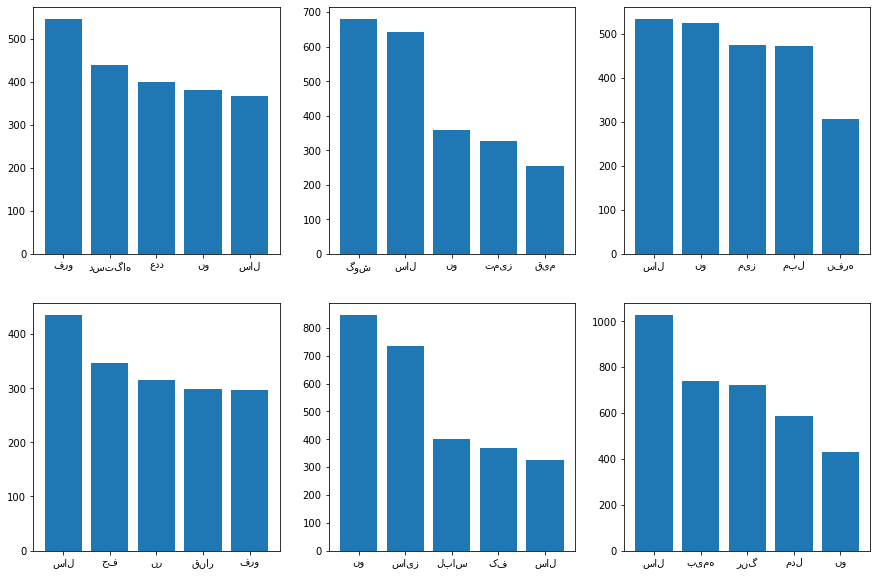

In [42]:
fig = plt.figure(figsize = (15, 10))
for i, category in enumerate(categories):
    tmp_df = words_df.iloc[i, 1:].sort_values(ascending=False)
    plt.subplot(2,3,i+1)
    plt.bar(tmp_df.keys()[:5],tmp_df[:5])

#### 4.1.6 - Assesments
We define several methods to test the "wellness" of our proposed model. These include the following:
- Prediction accuracy as computed over the whole dataset
- Precisions computed respective to each of the classes
- Recalls computed respective to each of the classes
- F1-scores computed respective to each of the classes
- Macro, Weighted, and Micro F1-scores calculated for the whole dataset

The F1-scores are used when False predictions do matter. The resean why we don't use precision or recall on their own, instead of computing their F1-score, is that precision gives importance to the false positive (FP) cases while recall, gives importance to the false negative (FN) predictions. combining them, we make sure that we're taking into account both the cases so that we can have a better estimation of the models total wellness, for not prediction falsely.

An example of having a high recall but low precision, is having a model that predicts 1 for every example in the test set in a binary class problem. This way, the recall will be equal to one, as we have FN=0. This model obviously does not provide a good fit and has a very low precision. Now suppose that we have a model that predicts True some True examples and is very picky. It also does not True for any negative examples as well a a bunch of positive examples. This model would then have a high precision and low recall. Therefore, we use the F1-score for assesments, as it takes the **harmonic mean** of both the precision and recall of the model. The advantages of this tipe of mean is as follows:
- Is not significantly affected by fluctuations
- Does not give weight to large values
- Is capable of algebric treatment

In the following cell, we iterate over the classes and compute precisions, recalls, and F1-scoresbased on the given formulas (in the CA descriptions) for each of them. We also store the F1-scores calculated in lists for further use.

**Note**: The report table was removed, and was replaced by the following results.

In [52]:
F1_scores = []
AS_F1_scores = []

for category in categories:
    class_predictions = predictions[predictions == category]
    class_AS_predictions = AS_predictions[AS_predictions == category]
    class_data_test = data_test[data_test['categories'] == category]
    
    class_detection_status = (class_predictions == ((data_test['categories'])[predictions == category]))
    AS_class_detection_status = (class_AS_predictions == ((data_test['categories'])[AS_predictions == category]))

    correct_detected_class = class_detection_status.sum()
    AS_correct_detected_class = AS_class_detection_status.sum()

    all_detected_class = len(class_predictions)
    AS_all_detected_class = len(class_AS_predictions)

    total_class = len(class_data_test)
    
    precision = correct_detected_class / all_detected_class
    AS_precision = AS_correct_detected_class / AS_all_detected_class
    
    recall = correct_detected_class / total_class
    AS_recall = AS_correct_detected_class / total_class
    
    F1 = 2 * (precision * recall) / (precision + recall)
    AS_F1 = 2 * (AS_precision * AS_recall) / (AS_precision + AS_recall)
    
    F1_scores.append(F1)
    AS_F1_scores.append(AS_F1)
    
    print('category: {}'.format(category))
    print('\t {2:10}: {0:30} AS_precision: {1:20}'.format(str("%.9f" % precision), str("%.9f" % AS_precision), 'precision'))
    print('\t {2:10}: {0:30} AS_recall: {1:20}'.format(str("%.9f" % recall), str("%.9f" % AS_recall), 'recall'))
    print('\t {2:10}: {0:30} AS_F1: {1:20}'.format(str("%.9f" % F1), str("%.9f" % AS_F1), 'F1'))
    print('\n')
    
    accuracy = (data_test['categories']==predictions).sum()/len(data_test['categories'])
    AS_accuracy = (data_test['categories']==AS_predictions).sum()/len(data_test['categories'])
    print('{2:10}: {0:30} AS_accuracy: {1:20}'.format(str("%.9f" % accuracy), str("%.9f" % AS_accuracy), 'accuracy'))
    print('\n')

category: businesses
	 precision : 0.212990937                    AS_precision: 0.760252366         
	 recall    : 0.940000000                    AS_recall: 0.803333333         
	 F1        : 0.347290640                    AS_F1: 0.781199352         


accuracy  : 0.392777778                    AS_accuracy: 0.861111111         


category: electronic-devices
	 precision : 0.861538462                    AS_precision: 0.849849850         
	 recall    : 0.186666667                    AS_recall: 0.943333333         
	 F1        : 0.306849315                    AS_F1: 0.894154818         


accuracy  : 0.392777778                    AS_accuracy: 0.861111111         


category: for-the-home
	 precision : 0.885245902                    AS_precision: 0.874524715         
	 recall    : 0.360000000                    AS_recall: 0.766666667         
	 F1        : 0.511848341                    AS_F1: 0.817051510         


accuracy  : 0.392777778                    AS_accuracy: 0.861111111      

Multi class metrics, are estimations of the wellness of a multi-class model results based on the precision, recall, and F1-score values. We also take three types of means out of the F1-scores respective to each of the classes to asses the wellness of the whole model. These are as follows:
- **Marco-F1**: Is the average of all F1-scores for all the classes
- **Weighted-F1**: Is the weighted average of all F1-scores for all the classes, weighted based on the number of examples per each class in the test set
- **Mirco-F1**: Is the same as the precision of the model, as computed by combining the class sets and taking the precision or recall

Here we implemented the two first averages in the following cell. Micro-F1 is the same as precision as already mentioned.

In [53]:
macro_F1 = sum(F1_scores)/len(F1_scores)
AS_macro_F1 = sum(AS_F1_scores)/len(F1_scores)

weighted_F1 = 0
AS_weighted_F1 = 0
for i, category in enumerate(categories):
    weighted_F1 += F1_scores[i] * (data_test['categories'] == category).sum()
    AS_weighted_F1 += AS_F1_scores[i] * (data_test['categories'] == category).sum()
weighted_F1 /= len(data_test)
AS_weighted_F1 /= len(data_test)

micro_F1 = (data_test['categories']==predictions).sum()/len(data_test['categories'])
AS_micro_F1 = (data_test['categories']==AS_predictions).sum()/len(data_test['categories'])
print('\t {2:10}: {0:30} AS_macro_F1: {1:20}'.format(str("%.9f" % macro_F1), str("%.9f" % AS_macro_F1), 'macro_F1'))
print('\t {2:10}: {0:30} AS_weighted_F1: {1:20}'.format(str("%.9f" % weighted_F1), str("%.9f" % AS_weighted_F1), 'weighted_F1'))
print('\t {2:10}: {0:30} AS_micro_F1: {1:20}'.format(str("%.9f" % micro_F1), str("%.9f" % AS_micro_F1), 'micro_F1'))
print('\n')

	 macro_F1  : 0.413015854                    AS_macro_F1: 0.860823241         
	 weighted_F1: 0.413015854                    AS_weighted_F1: 0.860823241         
	 micro_F1  : 0.392777778                    AS_micro_F1: 0.861111111         




The resulting values, show a that the AS model, has a good generalization to the test data (over 85 percent), but the bare Nauve Bayes model does not. The AS model shows good recall and precision for classes, and the F1 averages are also good. Also, it has accuracy and maxro averages of over 0.85 as needed in this CA.

<font color='green'>
We've reached the acceptance cutoff.

Bellow, 5 examples of our AS model (model with Additive Smoothing) predicting wrong are shown:

In [56]:
(data_test['categories'] == AS_predictions)[20:50]

20     True
21     True
22     True
23     True
24     True
25     True
26     True
27    False
28    False
29    False
30     True
31     True
32     True
33     True
34     True
35    False
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
45     True
46     True
47     True
48     True
49    False
dtype: bool

The biggest problem in our prediction not being true %100 of the time, is that we used an oversimplified model, i.e. the bag of words model, which did not take into account the relations between words in a sentense. Other causes may include descriptions not being clear, etc.